# 2. Using hard constraints - 1D harmonic oscillator

This notebook shows you how to use hard constraints when training FBPINNs.

> Note: before reading this notebook, make sure you have read example `1. Defining your own problem.ipynb` first.

# Problem overview

In this example, similar to `1. Defining your own problem.ipynb`, we will use a FBPINN to solve the 1D damped harmonic oscillator:

<img src="oscillator.gif" width="500">

The ordinary differential equation (ODE) is given by:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

and we solve the problem using the following initial conditions:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$


# Using hard boundary constraints

In `1. Defining your own problem.ipynb`, we used the following loss function to train the (FB)PINN:

$$
\mathcal{L}(\theta)= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
$$

When using this loss function, the boundary conditions are asserted in a **soft** fashion; if the two boundary loss terms are not fully minimised, the (FB)PINN will not precisely obey the boundary conditions.

### Hard constraints 
An alternative approach is to assert the boundary conditions in a **hard** fashion. To do so, we instead assume the neural network is part of a **solution ansatz**, $\hat u (t;\theta)$, which approximates the solution to the differential equation, and write

$$
\hat u (t;\theta) = \mathcal{C}[N\!N(t;\theta)] \approx u(t)~,
$$

where $\mathcal{C}$ is some **constraining operator** applied to the output of the (FB)PINN which asserts the boundary conditions in a hard fashion by mathematical construction of the solution ansatz.

### Hard constraints for the harmonic oscillator

For the problem above, we can assert hard boundary conditions by using the following constraining operator and solution ansatz:

$$
\hat u (t;\theta) = 1 + \tanh(t/\sigma)^2 N\!N(t;\theta)
$$

It can easily be shown that this ansatz automatically obeys the boundary conditions $u(0)=1$ and $u_t(0)=0$. Note $\sigma$ is a scalar hyperparameter which defines the width of the $\tanh$ constraining function.

Given the boundary conditions are already asserted in the ansatz, the boundary loss is no longer necessary and hard-constrained (FB)PINNs can be trained in a fully unsupervised fashion using the **physics loss only**.

# Workflow overview

We will use the following steps to train a FBPINN to solve the harmonic oscillator with hard boundary constraints:

1. Define a `constraining_fn` in the `fbpinns.problems.Problem` class
2. Train the FBPINN using this `Problem` class

## Step 1: Define a `constraining_fn` in the `fbpinns.problems.Problem` class

First, we will define a new `Problem` class by inheriting from the soft-constrained `HarmonicOscillator1D` class defined in `1. Defining your own problem.ipynb`.


Then, it is very simple to define a constraining operator: we simply need to specify the extra `Problem.constraining_fn` method:

### `Problem.constraining_fn(all_params, x_batch, u)`

This method should apply the constraining operator to the batch of FBPINN outputs (`u`) contained in a `jnp.array` of shape `(n, ud)` evaluated at a batch of input points (`x_batch`) contained in a `jnp.array` of shape `(n, xd)`. It should output the constrained solution, contained in a `jnp.array` of shape `(n, ud)`.

We apply the constraining operator given above to this new `Problem` class:

In [1]:
import jax.numpy as jnp
from fbpinns.problems import HarmonicOscillator1D

class HarmonicOscillator1DHardBC(HarmonicOscillator1D):
    """Solves the time-dependent damped harmonic oscillator using hard boundary conditions
          d^2 u      du
        m ----- + mu -- + ku = 0
          dt^2       dt

        Boundary conditions:
        u (0) = 1
        u'(0) = 0
    """

    @staticmethod
    def init_params(d=2, w0=20, sd=0.1):

        mu, k = 2*d, w0**2

        static_params = {
            "dims":(1,1),
            "d":d,
            "w0":w0,
            "mu":mu,
            "k":k,
            "sd":sd,
            }

        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,()),
            (0,(0,)),
            (0,(0,0))
        )
        return [[x_batch_phys, required_ujs_phys],]# only physics loss required in this case

    @staticmethod
    def constraining_fn(all_params, x_batch, u):

        sd = all_params["static"]["problem"]["sd"]
        x, tanh = x_batch[:,0:1], jnp.tanh

        u = 1 + (tanh(x/sd)**2) * u# applies hard BCs
        return u

    @staticmethod
    def loss_fn(all_params, constraints):

        mu, k = all_params["static"]["problem"]["mu"], all_params["static"]["problem"]["k"]

        # physics loss
        _, u, ut, utt = constraints[0]
        phys = jnp.mean((utt + mu*ut + k*u)**2)

        return phys

> Note, when inheriting the `HarmonicOscillator1D` class above, we also removed the boundary constraints from its `sample_constraints` and `loss_fn` methods, as they are no longer required.

## Step 2: Train the FBPINN using this `Problem` class

Finally, we can train the `FBPINN` using this new `Problem` class:

[INFO] 2025-03-02 17:57:11 - <fbpinns.constants.Constants object at 0x32f6bbf10>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0]), 'xmax': array([1])}
problem: <class '__main__.HarmonicOscillator1DHardBC'>
problem_init_kwargs: {'d': 2, 'w0': 80}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ])], 'subdomain_ws': [array([0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.15])], 'unnorm': (0.0, 1.0)}
network: <class 'fbpinns.networks.FCN'>
network_init_kwargs: {'layer_sizes': [1, 32, 1]}
n_steps: 20000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200,),)
n_test: (500,)
sampler: grid


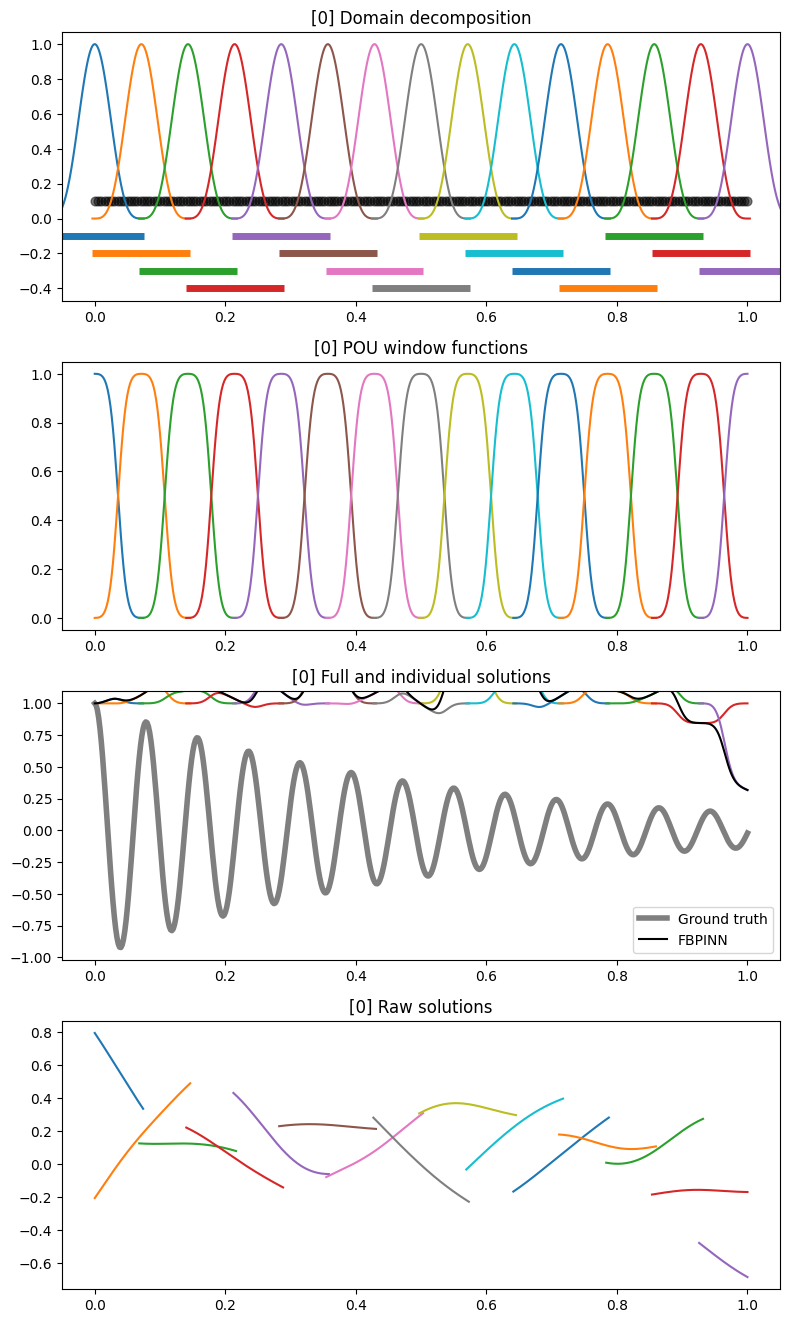

[INFO] 2025-03-02 17:57:13 - [i: 1000/20000] loss: 404433.0000 rate: 1125.8 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:14 - [i: 2000/20000] loss: 309199.5625 rate: 2861.1 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:14 - [i: 3000/20000] loss: 129292.5156 rate: 2871.6 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:14 - [i: 4000/20000] loss: 69234.8984 rate: 2859.5 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:15 - [i: 5000/20000] loss: 43083.6992 rate: 2856.9 elapsed: 0.00 hr test
fs (('test', <Figure size 800x1333.33 with 4 Axes>),)
True


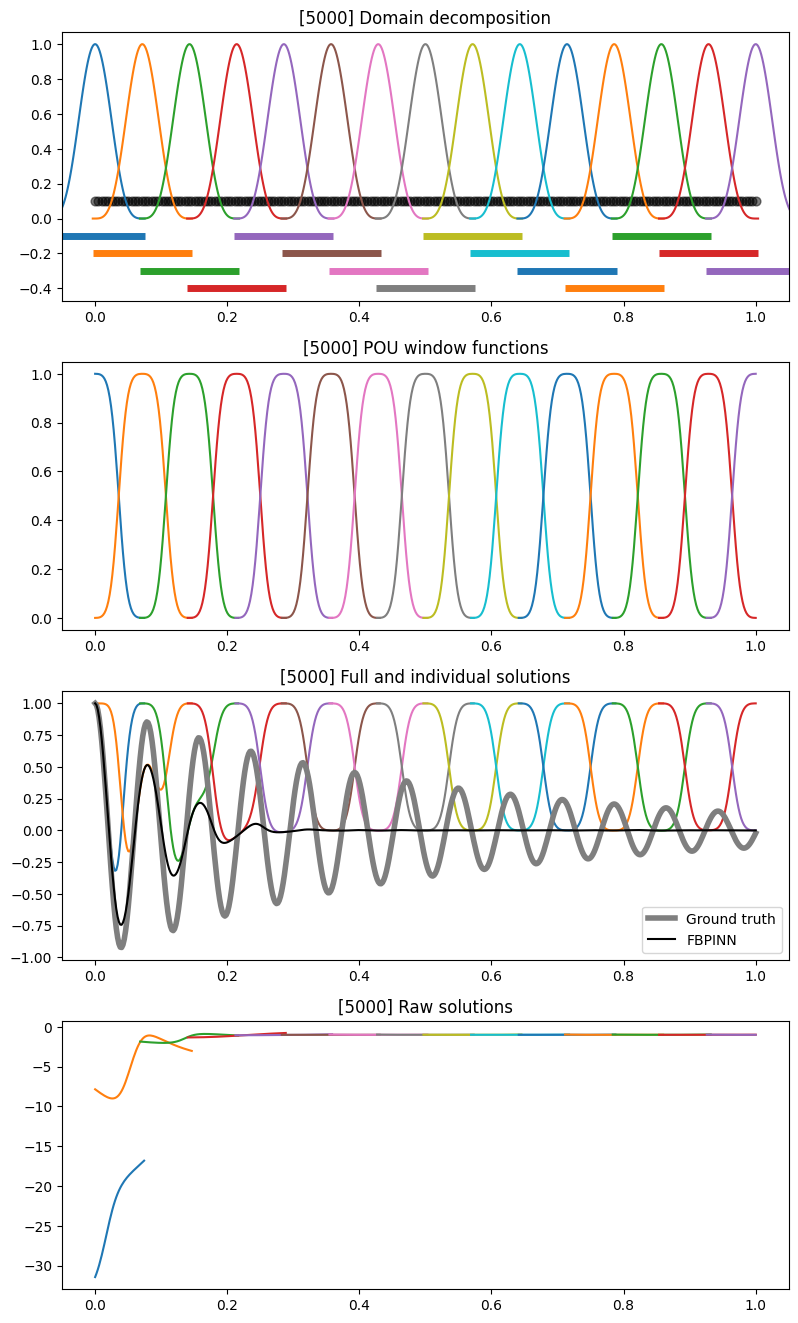

[INFO] 2025-03-02 17:57:16 - [i: 6000/20000] loss: 28244.6660 rate: 2724.3 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:16 - [i: 7000/20000] loss: 18916.4180 rate: 2732.7 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:16 - [i: 8000/20000] loss: 11159.4277 rate: 2820.7 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:17 - [i: 9000/20000] loss: 7050.2041 rate: 2713.6 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:17 - [i: 10000/20000] loss: 3968.8953 rate: 2840.2 elapsed: 0.00 hr test
fs (('test', <Figure size 800x1333.33 with 4 Axes>),)
True


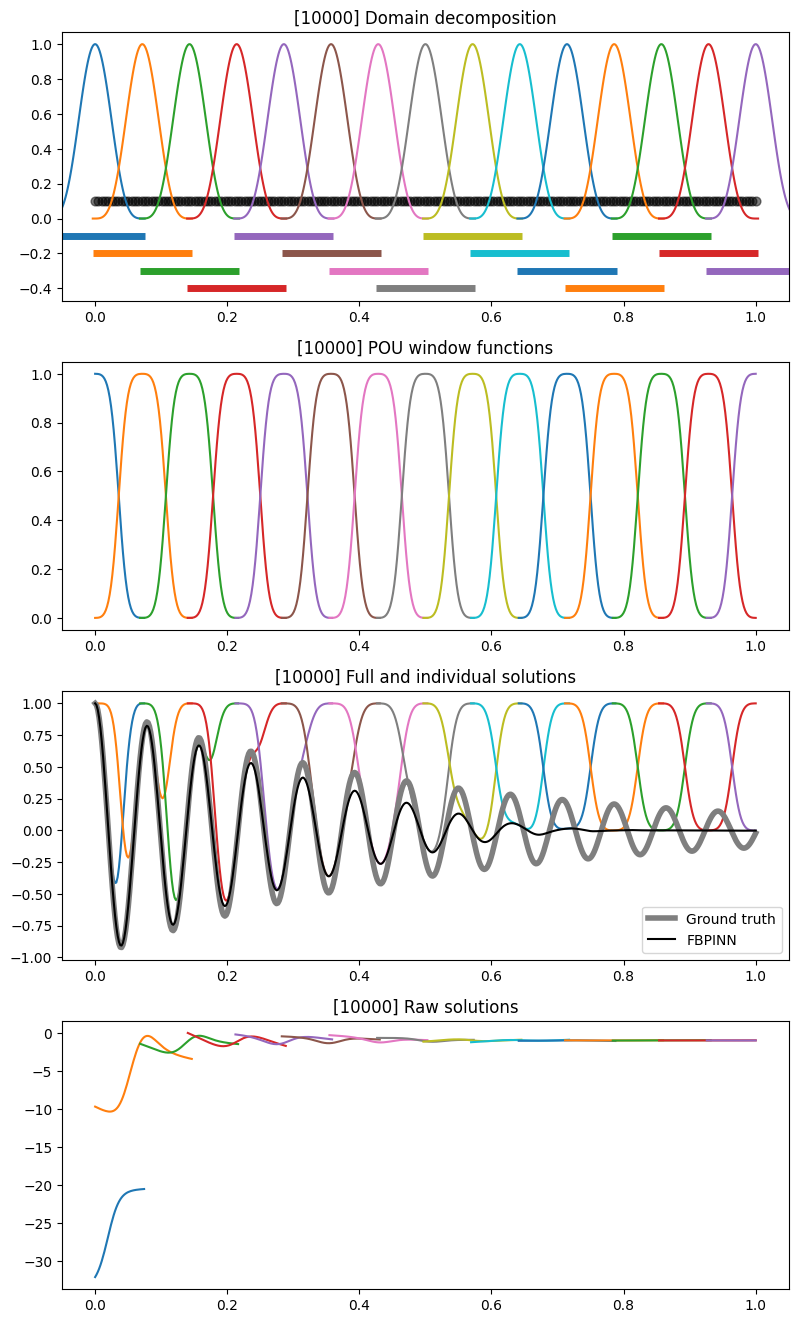

[INFO] 2025-03-02 17:57:18 - [i: 11000/20000] loss: 1941.4790 rate: 2541.9 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:18 - [i: 12000/20000] loss: 814.8700 rate: 2902.9 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:19 - [i: 13000/20000] loss: 349.3574 rate: 2887.1 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:19 - [i: 14000/20000] loss: 198.7948 rate: 2893.0 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:19 - [i: 15000/20000] loss: 80.8699 rate: 2883.8 elapsed: 0.00 hr test
fs (('test', <Figure size 800x1333.33 with 4 Axes>),)
True


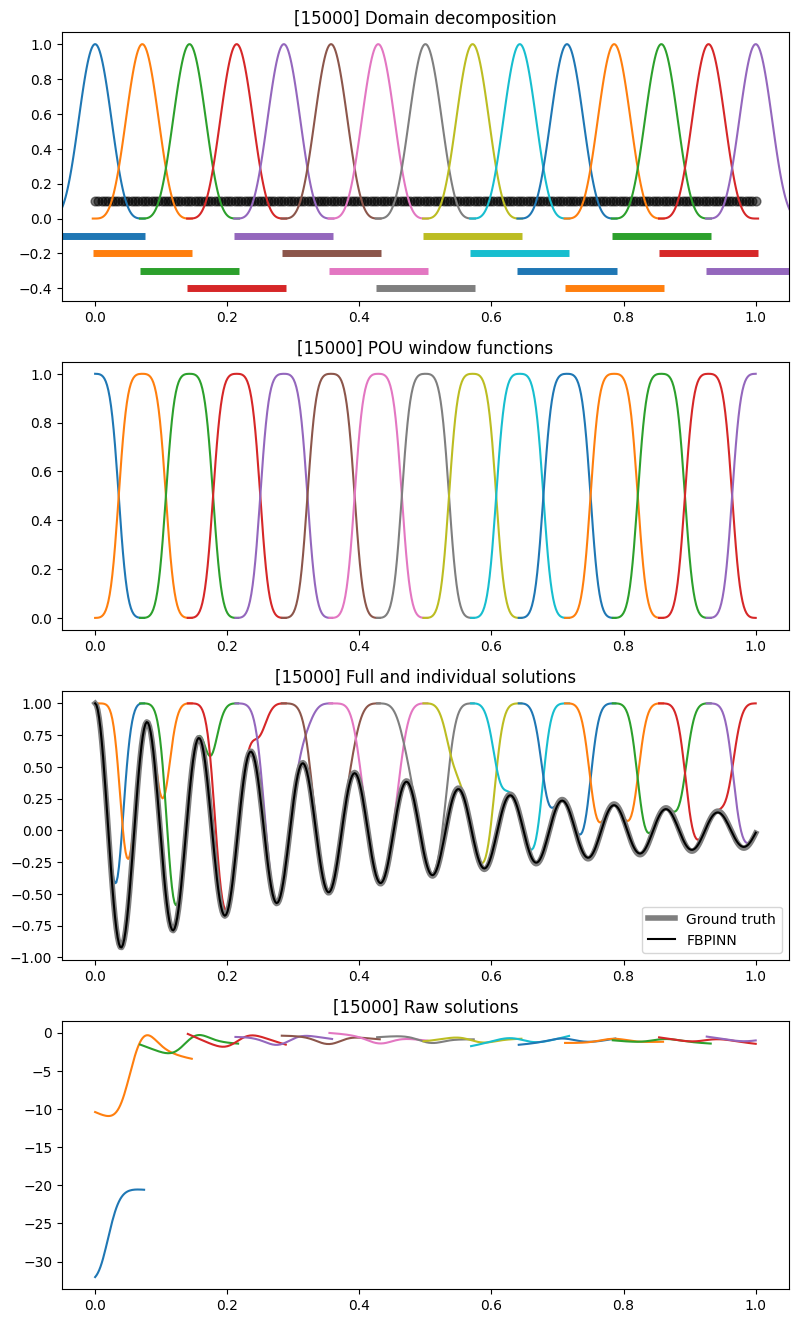

[INFO] 2025-03-02 17:57:20 - [i: 16000/20000] loss: 57.3644 rate: 2810.1 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:21 - [i: 17000/20000] loss: 85.2977 rate: 2986.3 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:21 - [i: 18000/20000] loss: 52.0725 rate: 2907.8 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:21 - [i: 19000/20000] loss: 30.8959 rate: 3011.7 elapsed: 0.00 hr test
[INFO] 2025-03-02 17:57:22 - [i: 20000/20000] loss: 26.6287 rate: 2975.1 elapsed: 0.00 hr test
fs (('test', <Figure size 800x1333.33 with 4 Axes>),)
True


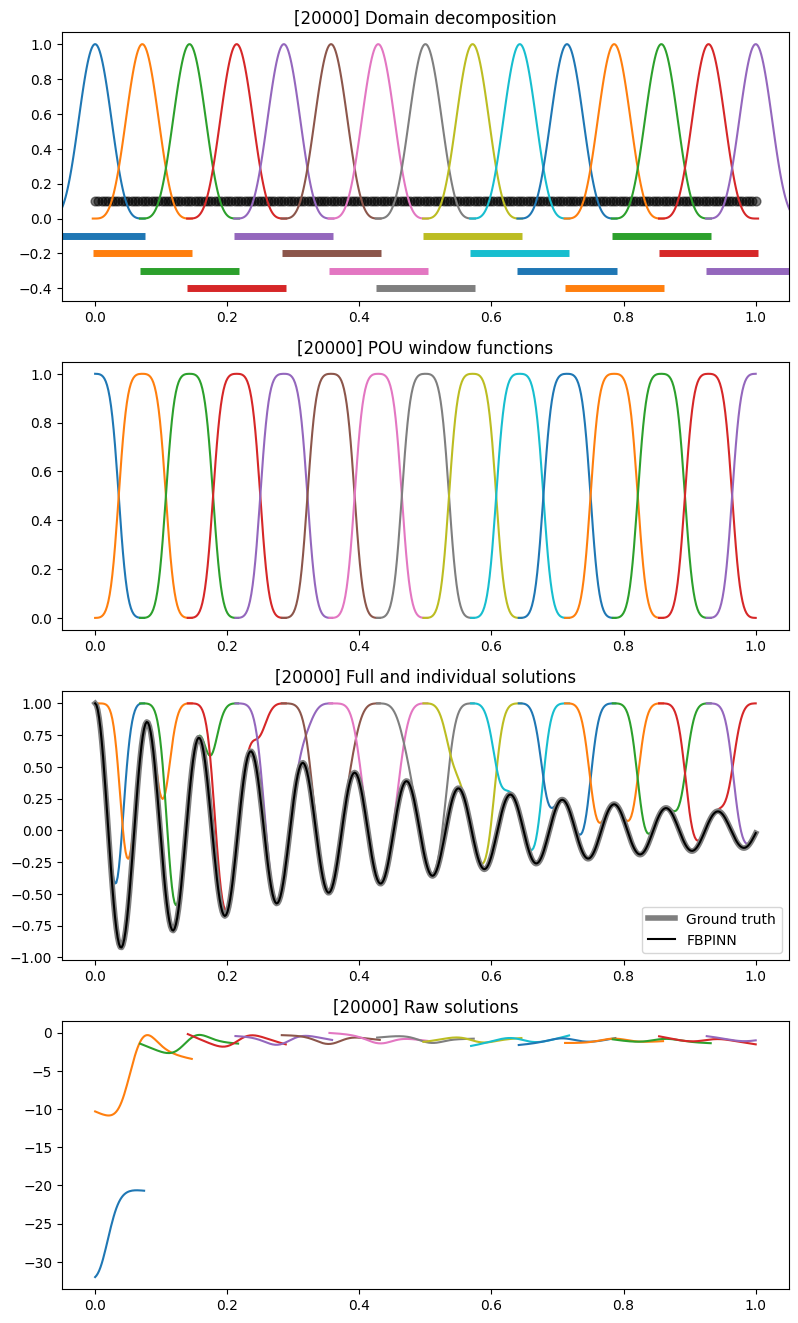

[INFO] 2025-03-02 17:57:22 - [i: 20000/20000] Training complete


In [4]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

c = Constants(
    domain=RectangularDomainND,# use a 1D problem domain [0, 1]
    domain_init_kwargs=dict(
        xmin=np.array([0,]),
        xmax=np.array([1,]),
    ),
    problem=HarmonicOscillator1DHardBC,
    problem_init_kwargs=dict(
        d=2, w0=80,# define the ODE parameters
    ),
    decomposition=RectangularDecompositionND,# use a rectangular domain decomposition
    decomposition_init_kwargs=dict(
        subdomain_xs=[np.linspace(0,1,15)],# use 15 equally spaced subdomains
        subdomain_ws=[0.15*np.ones((15,))],# with widths of 0.15
        unnorm=(0.,1.),# define unnormalisation of the subdomain networks
    ),
    network=FCN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        layer_sizes=[1,32,1],# with 2 hidden layers
    ),
    # network=ChebyshevKAN,# place a fully-connected network in each subdomain
    # network_init_kwargs=dict(
    #     input_dim=1,
    #     output_dim=1,
    #     degree=6
    # ),
    ns=((200,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=20000,# number of training steps
    # clear_output=True,
)

run = FBPINNTrainer(c)
all_params = run.train()